In [1]:
from typing import *
import numpy as np
from abc import ABC, abstractmethod
from main import *

## Estimators

After we had a rough simulation of how combat worked in D&D, we wrote estimator classes to estimate important values for us over the course of the battle. `Estimator` is a base class which implements Bayes' rule on discrete inputs - this works well enough for us as nothing in D&D is continuous. Given a number of options as input, it sets the prior to a uniform distribution across them, and defines functions for updating this prior given a measurement, along with functions to calculate the Maximum A Posteriori and the mean of the distribution. Each subclass of `Estimator` must define `model` - a function that takes in a measurement and returns the likelihood of the measurement happening given each value of the variable we are trying to estimate.

In [2]:
class Estimator(ABC):
    """
    Class to estimate a certain statistic

    Attributes:
        current_estimate: a numpy vector giving the probability of each option
        noptions: int, the number of options
        xvals: the range of possible values of the statistic to estimate
    """
    def __init__(self, noptions: int):
        self.current_estimate = np.ones((noptions,)) / noptions

    @property
    def noptions(self) -> int:
        return self.current_estimate.shape[0]

    @property
    def xvals(self) -> np.ndarray:
        return np.arange(self.noptions)

    def set_prior(self, prior: np.ndarray):
        """
        Sets the prior distribution

        :param prior: an ndarray, the prior distribution
        """
        assert sum(prior) == 1
        self.current_estimate = prior

    @abstractmethod
    def model(self, measurement) -> np.ndarray:
        """
        Calculates the probability of the measurement for each option

        :param measurement: the most recent measurement
        :return: a numpy vector with (noptions) elements, giving the probability of this measurement
          given the estimated value
        """
        pass

    def update(self, measurement):
        """
        Update the current belief given a measurement, as per Bayes' Rule

        :param measurement: the measured value
        """
        self.current_estimate *= self.model(measurement)
        self.current_estimate /= np.sum(self.current_estimate)

    def map(self) -> float:
        """
        :return: a float, the Maximum A Posteriori (or the average of them in the case of multiple) of the current estimate
        """
        highest = np.max(self.current_estimate)
        modes = self.current_estimate == highest
        return np.sum(self.current_estimate[modes]) / len(modes)

    def mean(self) -> float:
        """
        :return: a float, the weighted mean of the current estimate
        """
        return sum(self.current_estimate * np.arange(self.current_estimate.shape[0]))

We then made two subclasses of `Estimator` - `ModifierEstimator` and `ACEstimator`. These each define their own models given a certain measurement. Here is `ACEstimator`:

In [3]:
class ACEstimator(Estimator):
    def __init__(self):
        super().__init__(31)  # 0 to 30

    def model(self, measurement: Tuple[int, bool]):
        """
        Calculates the probability of the measurement for each option

        :param measurement: a tuple - the most recent roll followed by whether it hit
        :return: a numpy vector with (noptions) elements, giving the probability of this measurement given the
            estimated value
        """
        roll, hit = measurement
        if hit:
            return self.xvals <= roll
        return self.xvals > roll

The input to this function is two values: first, the roll to hit, and second, whether or not that roll hit (whether it passed the AC). This function is very basic, as the AC determines whether or not the attack hits - i.e. for each AC, the given measurement is either completely possible (probability 1) or completely impossible (probability 0).

`ModifierEstimator` has a different `model` function. Note that the `xvals` property is overriden as modifiers can be negative

In [4]:
class ModifierEstimator(Estimator):
    def __init__(self):
        super().__init__(21)  # -5 to 15

    @property
    def xvals(self) -> np.ndarray:
        return np.arange(self.noptions) - 5

    def model(self, measurement: int) -> np.ndarray:
        """
        Calculates the probability of the measurement for each option

        :param measurement: an int, the most recent roll
        :return: a numpy vector with (noptions) elements, giving the probability of this measurement given the
            estimated value
        """
        poss_rolls = measurement - self.xvals
        in_range = (1 <= poss_rolls) & (poss_rolls <= 20)
        return in_range / 20

The measurement for this model is the roll that the opponent made. Given each possible modifier from -5 to 15, there is either a 5% chance of seeing that roll, or a 0% chance of seeing that roll. This function sets those probabilities accordingly.

## Results

Since both the prior we used and the model for each statistic are uniform distributions, the estimator only gives uniform distributions back. However, the range of that distribution shrinks over time. We can plot this shrinking:

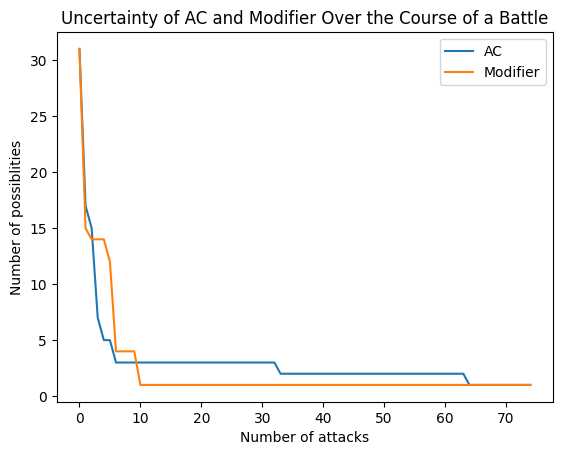

In [5]:
acrange, modrange = simulate_battle()
display_range_plots(acrange, modrange)

This graph is roughly exponential decay. However, the exact speed of the decay varies a lot, as can be seen if many graphs are generated. The question became, how many data points are needed until each statistic is known? To calculate this, we ran 10,000 battle simulations and saved how long it took until each statistic was known, and plotted a histogram of these values.

Mean is 30.138, stdev is 22.066
Median is 24
Skew is 1.63, kurtosis is 4.01


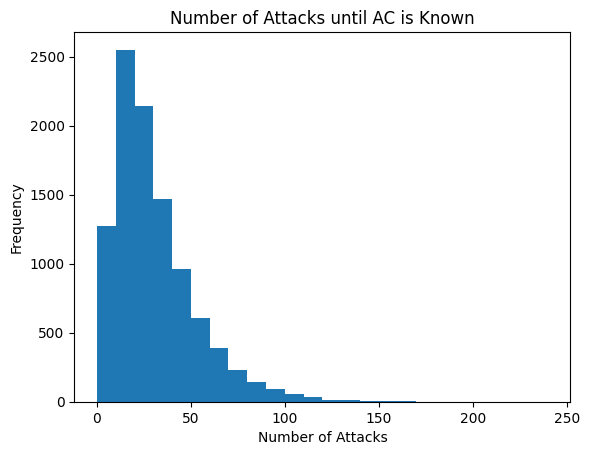

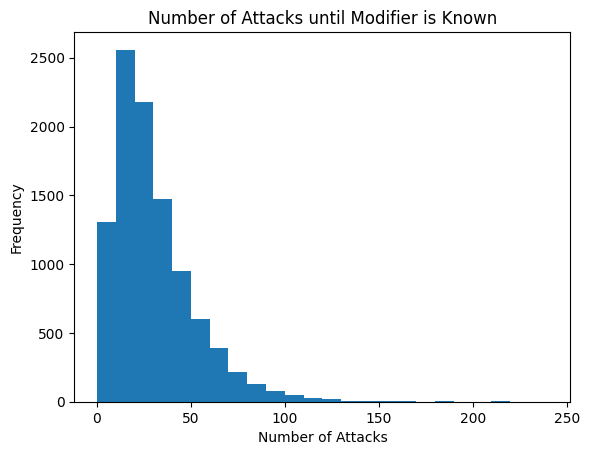

In [6]:
main()

These two distributions are pretty much exactly identical. This makes sense - the problem is merely two sides of the same coin. Either way, each roll rules out any choices above or below it (depending on the roll) until only one option is left.